In [8]:
import jupyterconfig
import matplotlib.pyplot as plt
import dbtools as dbt
import datetime
import seaborn as sns

sns.set()
%matplotlib inline

In [109]:
rdt_q  = """
SELECT * FROM tweetcounts
WHERE "user" = 'realDonaldTrump'
"""

tweets = dbt.select(rdt_q, con=dbt.PI_PROD)
tweets['prevt'] = tweets['tweets'].shift(1)
tweets = tweets[tweets['tweets']!=tweets['prevt']]
tweets['tweets'] -= tweets['tweets'].min()
tweets['tweets'] += 1
tweets = tweets.reset_index(drop=True)
tweets['date'] = tweets['update_ts'].map(
    lambda x: x.to_pydatetime().date())
tweets['wd'] = tweets['date'].map(lambda x: '{:%a}'.format(x))
tweets.tail()

,update_ts,user,tweets,prevt,date,wd
777,2020-02-12 18:25:16.732173,realDonaldTrump,605,48980.0,2020-02-12,Wed
778,2020-02-12 20:24:51.498994,realDonaldTrump,606,48979.0,2020-02-12,Wed
779,2020-02-12 20:25:57.089653,realDonaldTrump,605,48980.0,2020-02-12,Wed
780,2020-02-12 20:58:51.794374,realDonaldTrump,606,48979.0,2020-02-12,Wed
781,2020-02-12 20:59:52.023116,realDonaldTrump,605,48980.0,2020-02-12,Wed


In [110]:
tweet_count = tweets['tweets'].max() - tweets['tweets'].min()
day_count = (tweets['date'].max() - tweets['date'].min()).days
tpd = tweet_count / days
print(f'Tweets: {tweet_count}')
print(f'Days: {day_count}')
print(f'Tweet Rate: {tpd:.1f}')

Tweets: 605
Days: 16
Tweet Rate: 37.8


(array([737453., 737455., 737456., 737458., 737460., 737462., 737464.,
        737466., 737468.]), <a list of 9 Text xticklabel objects>)

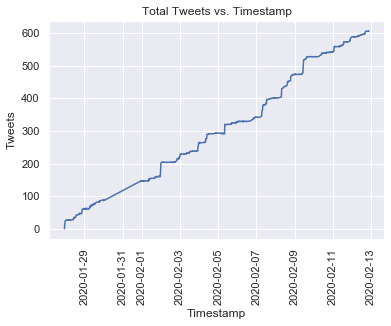

In [111]:
plt.figure()
plt.plot(tweets['update_ts'], tweets['tweets'])
plt.title('Total Tweets vs. Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Tweets')
plt.xticks(rotation=90)

In [112]:
date_group = tweets.groupby('date')
date_stats = date_group[['tweets', 'wd']].nth(-1)
date_stats = date_stats.reset_index()
date_stats['chg'] = date_stats['tweets'] - date_stats['tweets'].shift(1)
date_stats.tail()

,date,tweets,wd,chg
12,2020-02-08,473,Sat,72.0
13,2020-02-09,527,Sun,54.0
14,2020-02-10,542,Mon,15.0
15,2020-02-11,588,Tue,46.0
16,2020-02-12,605,Wed,17.0


(array([737451., 737453., 737455., 737456., 737458., 737460., 737462.,
        737464., 737466.]), <a list of 9 Text xticklabel objects>)

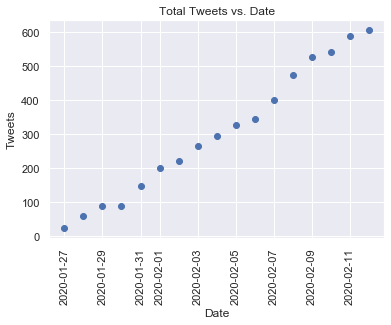

In [113]:
plt.figure()
plt.plot(date_stats['date'], date_stats['tweets'], 'o')
plt.title('Total Tweets vs. Date')
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.xticks(rotation=90)

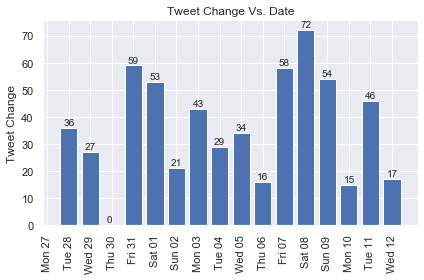

In [114]:
plt.figure()
tick_labels = ['{:%a %d}'.format(x)
               for x in date_stats['date'].tolist()]
plt.bar(date_stats['date'].index,
        date_stats['chg'],
        tick_label=tick_labels)
plt.xticks(rotation=90)
for i,r in date_stats.iterrows():
    plt.annotate('{:,.0f}'.format(r['chg']),
                 (i - 0.25, r['chg'] + 1))
plt.title('Tweet Change Vs. Date')
plt.ylabel('Tweet Change')
plt.tight_layout()

In [135]:
wd_temp = date_stats.copy()
wd_temp['i'] = wd_temp['date'].map(lambda x: '{:%w}'.format(x))
wd_group = wd_temp.groupby('wd')
wd_stats = wd_group.agg({'chg': ['mean', 'std', 'count'],
                         'i': ['max']})
wd_stats.columns = [x[0] + x[1].title()
                    for x in wd_stats.columns]
wd_stats = wd_stats.rename(columns={'iMax': 'dayIdx'})
wd_stats = wd_stats.sort_values('dayIdx')
wd_stats = wd_stats.drop('dayIdx', axis=1)
wd_stats

,chgMean,chgStd,chgCount
wd,,,
Sun,37.5,23.334524,2
Mon,29.0,19.798990,2
Tue,37.0,8.544004,3
Wed,26.0,8.544004,3
Thu,8.0,11.313708,2
Fri,58.5,0.707107,2
Sat,62.5,13.435029,2
